### **LLaMA-2 Model Architecture**

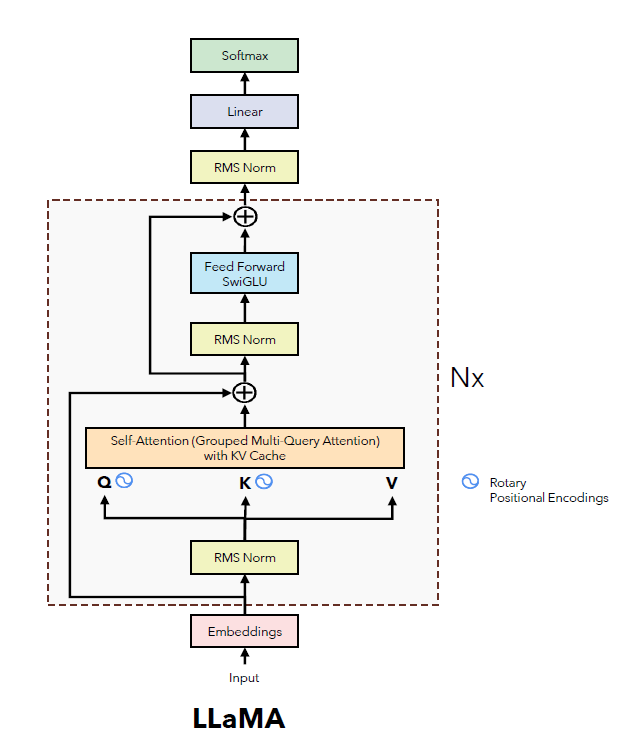

#### **Import Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
from typing import Optional
import time
from pathlib import Path
import json
from sentencepiece import SentencePieceProcessor
from tqdm import tqdm

#### **Defining Model Arguments**

dataclass in Python automatically generates boilerplate code like `__init__`, `__repr__`, and `__eq__` for classes, making them cleaner and easier to use for storing data.

Example Code:
```
@dataclass
class DummyClass:
    dim: int
    n_layers: int = 32
object = DummyClass(512,64)
print(object) # DummyClass(dim=512,n_layers=64)
```

In [ ]:
@dataclass
class ModelArgs:
    dim: int = 4096
    n_layers: int = 32
    n_heads: int = 32
    n_kv_heads: Optional[int] = None
    vocab_size: int = -1 # Later set in the build method
    multiple_of: int = 256
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5

    # Needed for KV cache
    max_batch_size: int = 32
    max_seq_len: int = 2048

    device: str = None

#### **RMS Norm**

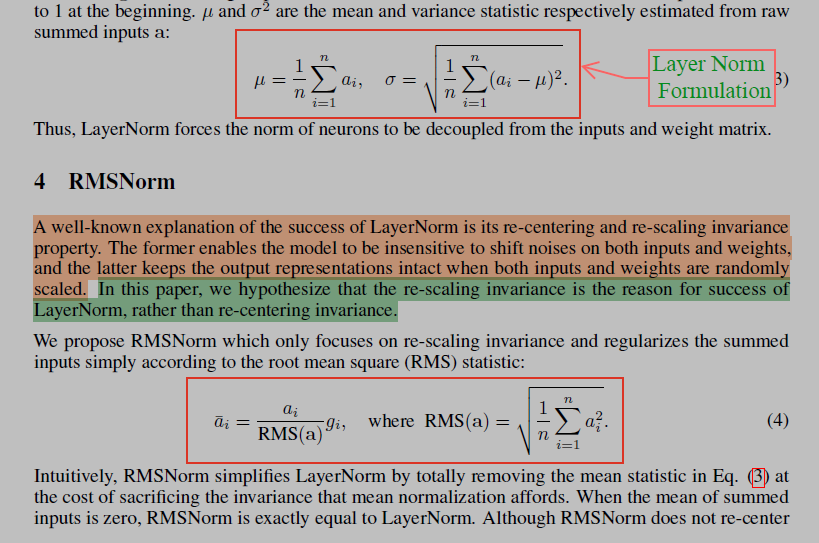

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        # The gamma parameter
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x: torch.Tensor):
        # (B, Seq_Len, Dim) * (B, Seq_Len, 1) = (B, Seq_Len, Dim)
        # rsqrt: 1 / sqrt(x)
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x: torch.Tensor):
        # (Dim) * (B, Seq_Len, Dim) = (B, Seq_Len, Dim)
        return self.weight * self._norm(x.float()).type_as(x)

#### **Rotary Positional Embeddings(RoPE)**

RoPE (Rotary Position Embedding) encodes relative positional information directly into the query and key vectors through rotation in the embedding space. Unlike absolute position embeddings, it naturally models token order and relative distances, making attention more position-aware and generalizable.

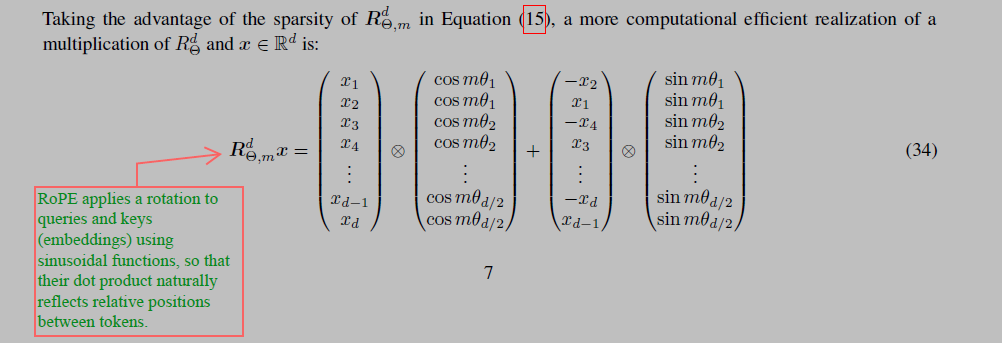

##### **PreComputing Cosine-Sine Matrices for each positions**

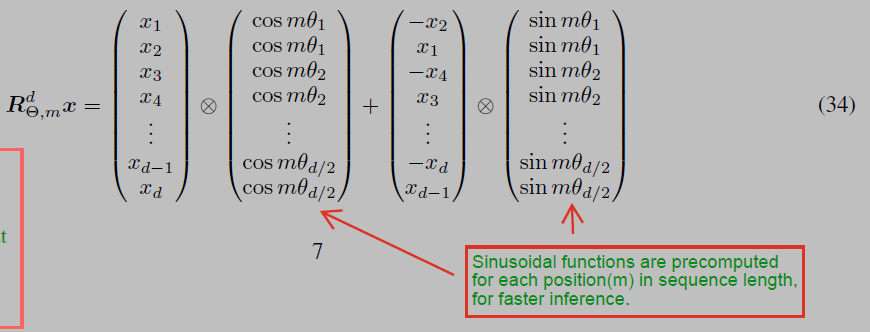

In [ ]:
def precompute_theta_pos_frequencies(head_dim: int, seq_len: int, device: str, theta: float = 10000.0):
    # As written in the paragraph 3.2.2 of the paper
    # >> In order to generalize our results in 2D to any xi ∈ Rd where **d is even**, [...]
    assert head_dim % 2 == 0, "Dimension must be divisible by 2"
    # Build the theta parameter
    # According to the formula theta_i = 10000^(-2(i-1)/dim) for i = [1, 2, ... dim/2]
    # Shape: (Head_Dim / 2)
    theta_numerator = torch.arange(0, head_dim, 2).float()
    # Shape: (Head_Dim / 2)
    theta = 1.0 / (theta ** (theta_numerator / head_dim)).to(device) # (Dim / 2)
    # Construct the positions (the "m" parameter)
    # Shape: (Seq_Len)
    m = torch.arange(seq_len, device=device)
    # Multiply each theta by each position using the outer product.
    # Shape: (Seq_Len) outer_product* (Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
    freqs = torch.outer(m, theta).float()
    # We can compute complex numbers in the polar form c = R * exp(m * theta), where R = 1 as follows:
    # (Seq_Len, Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
    freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_complex

##### **Applying Rotary Embeddings**

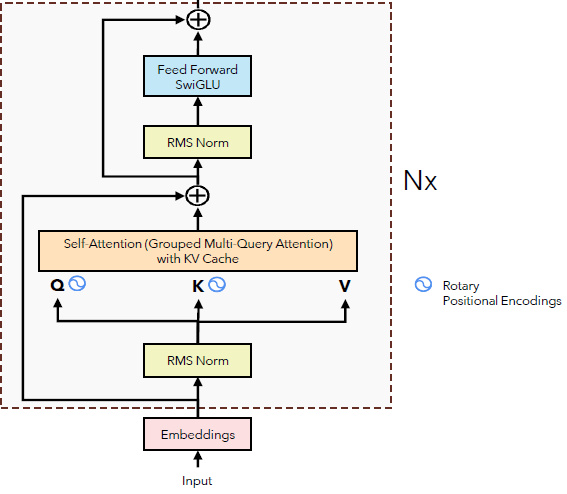

The function `apply_rotary_embeddings` integrates Rotary Embeddings into Queries and Keys within the Self-Attention mechanism, right after the RMSNorm step, as illustrated above. This contrasts with Vanilla Transformers, where `positional embeddings` are added directly to the input token embeddings at the very start of the model.

In [ ]:
def apply_rotary_embeddings(x: torch.Tensor, freqs_complex: torch.Tensor, device: str):
    # Separate the last dimension pairs of two values, representing the real and imaginary parts of the complex number
    # Two consecutive values will become a single complex number
    # (B, Seq_Len, H, Head_Dim) -> (B, Seq_Len, H, Head_Dim/2)
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    # Reshape the freqs_complex tensor to match the shape of the x_complex tensor. So we need to add the batch dimension and the head dimension
    # (Seq_Len, Head_Dim/2) --> (1, Seq_Len, 1, Head_Dim/2)
    freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)
    # Multiply each complex number in the x_complex tensor by the corresponding complex number in the freqs_complex tensor
    # Which results in the rotation of the complex number as shown in the Figure 1 of the paper
    # (B, Seq_Len, H, Head_Dim/2) * (1, Seq_Len, 1, Head_Dim/2) = (B, Seq_Len, H, Head_Dim/2)
    x_rotated = x_complex * freqs_complex
    # Convert the complex number back to the real number
    # (B, Seq_Len, H, Head_Dim/2) -> (B, Seq_Len, H, Head_Dim/2, 2)
    x_out = torch.view_as_real(x_rotated)
    # (B, Seq_Len, H, Head_Dim/2, 2) -> (B, Seq_Len, H, Head_Dim)
    x_out = x_out.reshape(*x.shape)
    return x_out.type_as(x).to(device)

#### **Self-Attention(GQA-Grouped Query Attention) with KV-Cache**

In [ ]:
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    batch_size, seq_len, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        # (B, Seq_Len, N_KV_Heads, 1, Head_Dim)
        x[:, :, :, None, :]
        # (B, Seq_Len, N_KV_Heads, N_Rep, Head_Dim)
        .expand(batch_size, seq_len, n_kv_heads, n_rep, head_dim)
        # (B, Seq_Len, N_KV_Heads * N_Rep, Head_Dim)
        .reshape(batch_size, seq_len, n_kv_heads * n_rep, head_dim)
    )


In Vanilla Transformers, each decoding step recomputes Keys and Values for all past tokens, which is very expensive for long sequences.

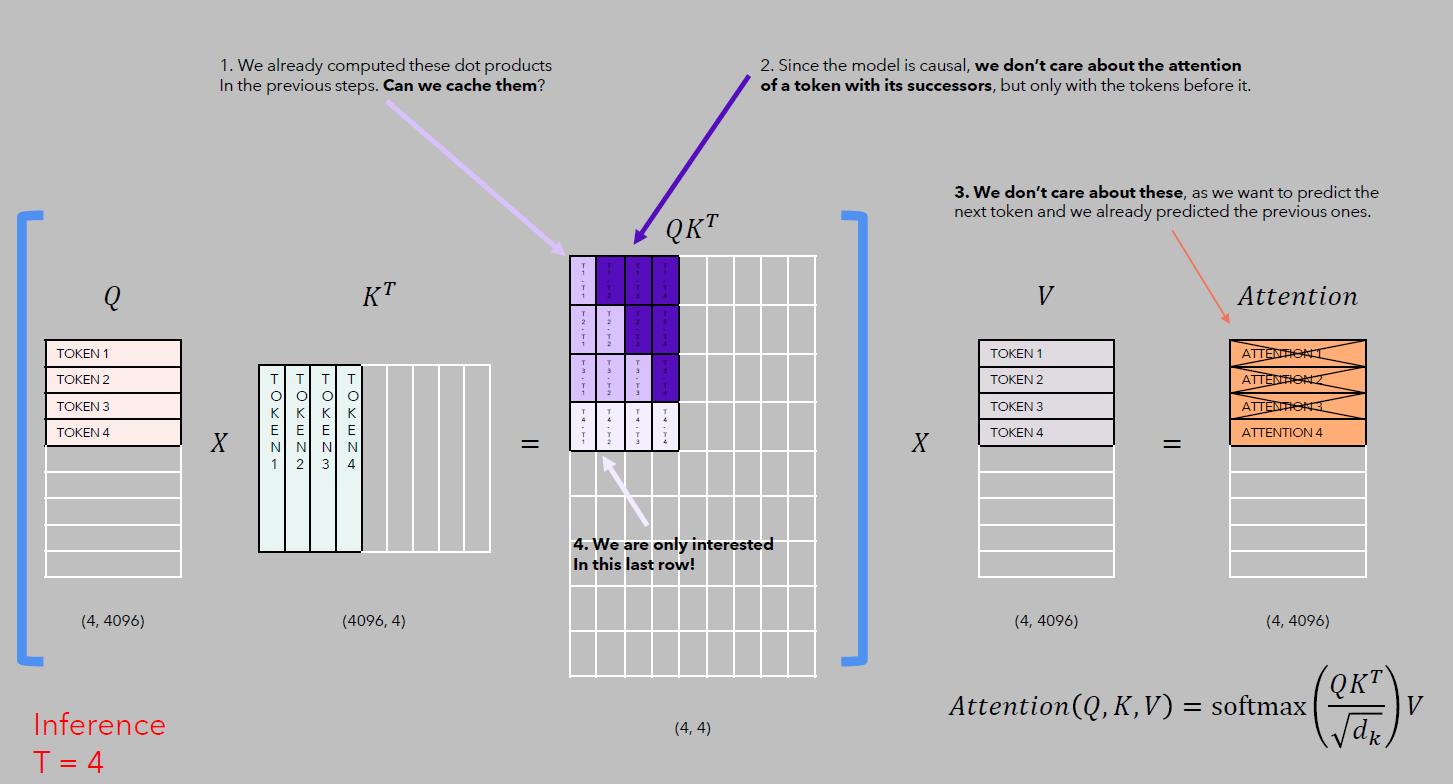  
> Source: Lecture slides by Umar Jamil 

LLaMA-2 introduces a KV Cache, where previously computed Keys and Values are stored and reused instead of recalculated.

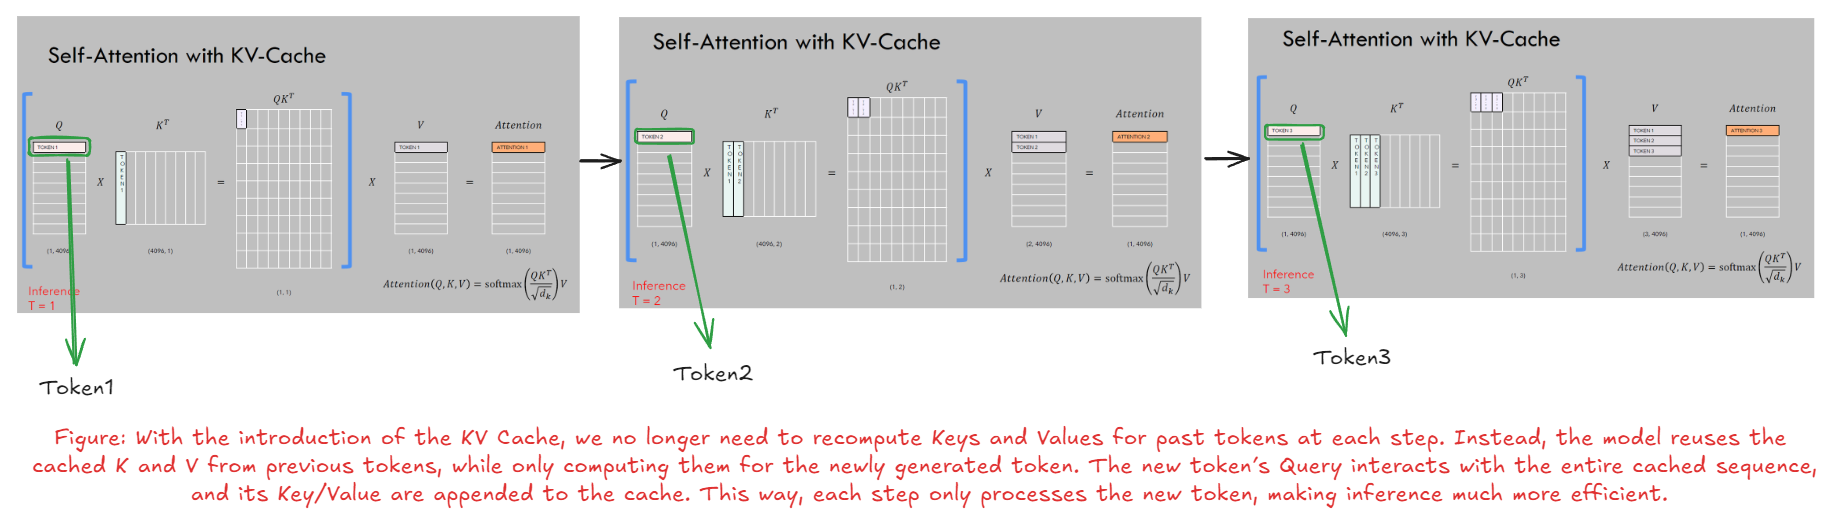

At each new step, only the current token’s Queries, Keys, and Values are computed; the new K and V are appended to the cache, while Queries attend over the full cached sequence.
This makes autoregressive inference far more efficient, reducing computation from O(n²) per step to O(n), while preserving the correctness of attention.

The function below shows this process, where Rotary Position Embeddings are first applied to Queries and Keys, followed by updating and reusing the KV Cache during the Self-Attention mechanism. Also, LLaMA uses a variant of self-attention mechanism called Grouped Query Attention or GQA, which reduces the memory and compute cost of attention by grouping Query heads to share the same Keys and Values. This offers a middle ground between Multi-Head Attention (independent K/V per head) and Multi-Query Attention (single shared K/V), while maintaining model quality. It is particularly effective in scaling large language models efficiently.

In [6]:
def forward(
    self,
    x: torch.Tensor,
    start_pos: int,
    freqs_complex: torch.Tensor
):
    batch_size, seq_len, _ = x.shape  # (B, 1, Dim)
    print("x ",x.shape)
    # (B, 1, Dim) -> (B, 1, H_Q * Head_Dim)
    xq = self.wq(x)
    print("xq ",xq.shape)
    # (B, 1, Dim) -> (B, 1, H_KV * Head_Dim)
    xk = self.wk(x)
    print("xk ",xk.shape)
    # (B, 1, Dim) -> (B, 1, H_KV * Head_Dim)
    xv = self.wv(x)
    print("xv ",xv.shape)

    # (B, 1, H_Q * Head_Dim) -> (B, 1, H_Q, Head_Dim)
    xq = xq.view(batch_size, seq_len, self.n_heads_q, self.head_dim)
    print("xq ",xq.shape)
    # (B, 1, H_KV * Head_Dim) -> (B, 1, H_KV, Head_Dim)
    xk = xk.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)
    print("xk ",xk.shape)
    # (B, 1, H_KV * Head_Dim) -> (B, 1, H_KV, Head_Dim)
    xv = xv.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)
    print("xk ",xk.shape)

    # (B, 1, H_Q, Head_Dim) --> (B, 1, H_Q, Head_Dim)
    xq = apply_rotary_embeddings(xq, freqs_complex, device=x.device)
    print("xq ROPE: ",xq.shape)
    # (B, 1, H_KV, Head_Dim) --> (B, 1, H_KV, Head_Dim)
    xk = apply_rotary_embeddings(xk, freqs_complex, device=x.device)
    print("xk ROPE: ",xk.shape)

    # Replace the entry in the cache
    self.cache_k[:batch_size, start_pos : start_pos + seq_len] = xk
    self.cache_v[:batch_size, start_pos : start_pos + seq_len] = xv

    # (B, Seq_Len_KV, H_KV, Head_Dim)
    keys = self.cache_k[:batch_size, : start_pos + seq_len]
    print("keys ",keys.shape)
    # (B, Seq_Len_KV, H_KV, Head_Dim)
    values = self.cache_v[:batch_size, : start_pos + seq_len]
    print("values ",values.shape)
    # Since every group of Q shares the same K and V heads, just repeat the K and V heads for every Q in the same group.

    # (B, Seq_Len_KV, H_KV, Head_Dim) --> (B, Seq_Len_KV, H_Q, Head_Dim)
    keys = repeat_kv(keys, self.n_rep)
    print("keys after repetition",keys.shape)
    # (B, Seq_Len_KV, H_KV, Head_Dim) --> (B, Seq_Len_KV, H_Q, Head_Dim)
    values = repeat_kv(values, self.n_rep)
    print("values after repetition",values.shape)

    # (B, 1, H_Q, Head_Dim) -> (B, H_Q, 1, Head_Dim)
    xq = xq.transpose(1, 2)
    print("xq transpose ",xq.shape)
    # (B, Seq_Len_KV, H_Q, Head_Dim) -> (B, H_Q, Seq_Len_KV, Head_Dim)
    keys = keys.transpose(1, 2)
    print("keys transpose ",keys.shape)
    # (B, Seq_Len_KV, H_Q, Head_Dim) -> (B, H_Q, Seq_Len_KV, Head_Dim)
    values = values.transpose(1, 2)
    print("values transpose ",values.shape)

    # (B, H_Q, 1, Head_Dim) @ (B, H_Q, Head_Dim, Seq_Len_KV) -> (B, H_Q, 1, Seq_Len_KV)
    scores = torch.matmul(xq, keys.transpose(2, 3)) / math.sqrt(self.head_dim)
    print("scores ",scores.shape)
    # (B, H_Q, 1, Seq_Len_KV) -> (B, H_Q, 1, Seq_Len_KV)
    scores = F.softmax(scores.float(), dim=-1).type_as(xq)

    # (B, H_Q, 1, Seq_Len) @ (B, H_Q, Seq_Len_KV, Head_Dim) -> (B, H_Q, 1, Head_Dim)
    output = torch.matmul(scores, values)
    print("output before wo ",output.shape)
    # (B, H_Q, 1, Head_Dim) -> (B, 1, H_Q, Head_Dim) -> (B, 1, Dim)
    output = (output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1))
    print("output after reshape ",output.shape)
    output = self.wo(output)
    print("output after wo ",output.shape) # (B, 1, Dim) -> (B, 1, Dim)
    return output 

#### **Feed Forward Network**

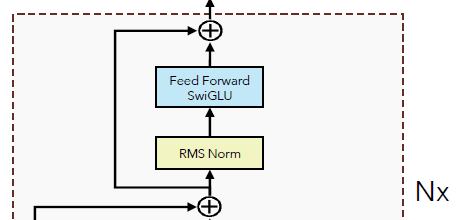

In LLaMA, each Transformer block contains a Feed Forward Network (FFN) after the Self-Attention layer. But instead of the standard ReLU or GELU activations used in vanilla Transformers, LLaMA employs the SwiGLU activation function, which improves expressiveness and training stability.

#### Some info about SwiGLU:

SwiGLU is a gated linear unit variant that combines a linear projection with the SiLU (Sigmoid Linear Unit) activation function. It is defined as:  

$$
\text{SwiGLU}(x) = (xW_1) \odot \text{SiLU}(xW_2)
$$  

where $W_1, W_2$ are learned weight matrices, and $\odot$ denotes elementwise multiplication.  
This formulation introduces a gating effect, allowing the model to better control information flow and capture richer representations compared to GELU.


In [ ]:
class FeedForward(nn.Module):
    def __init__(
        self,
        args: ModelArgs
    ):
        super().__init__()

        hidden_dim = 4 * args.dim
        hidden_dim = int(2 * hidden_dim / 3)
        if args.ffn_dim_multiplier is not None:
            hidden_dim = int(args.ffn_dim_multiplier * hidden_dim)
        # Round the hidden_dim to the nearest multiple of the multiple_of parameter
        hidden_dim = args.multiple_of * ((hidden_dim + args.multiple_of - 1) // args.multiple_of)

        self.w1 = nn.Linear(args.dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, args.dim, bias=False)
        self.w3 = nn.Linear(args.dim, hidden_dim, bias=False)

    def forward(self, x: torch.Tensor):
        # (B, Seq_Len, Dim) --> (B, Seq_Len, Hidden_Dim)
        swish = F.silu(self.w1(x))
        # (B, Seq_Len, Dim) --> (B, Seq_Len, Hidden_Dim)
        x_V = self.w3(x)
        # (B, Seq_Len, Hidden_Dim) * (B, Seq_Len, Hidden_Dim) --> (B, Seq_Len, Hidden_Dim)
        x = swish * x_V
        # (B, Seq_Len, Hidden_Dim) --> (B, Seq_Len, Dim)
        x = self.w2(x)
        return x



#### **Encoder**


The Encoder in LLaMA combines all the above components into a single layer. Each encoder layer consists of:  

1. **Grouped Query Attention (with RoPE)** – captures contextual dependencies across the sequence.  
2. **RMS Normalization** – applied before each sublayer to stabilize training.  
3. **Feed Forward Network with SwiGLU** – projects representations into higher dimensions, applies the SwiGLU activation for gated non-linearity, and projects back.  
4. **Residual Connections** – ensure stable gradient flow and better information preservation.  

An encoder layer can be summarized as:  

$$
h = x + \mathrm{Attention}(\mathrm{RMSNorm}(x))
$$

$$
\mathrm{EncoderLayer}(x) = h + \mathrm{FFN}(\mathrm{RMSNorm}(h))
$$



In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, args: ModelArgs):
        super().__init__()

        self.n_heads = args.n_heads
        self.dim = args.dim
        self.head_dim = args.dim // args.n_heads

        self.attention = SelfAttention(args)
        self.feed_forward = FeedForward(args)

        # Normalization BEFORE the attention block
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps)
        # Normalization BEFORE the feed forward block
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps)
    
    def forward(self, x: torch.Tensor, start_pos: int, freqs_complex: torch.Tensor):
        # (B, Seq_Len, Dim) + (B, Seq_Len, Dim) --> (B, Seq_Len, Dim)
        h = x + self.attention.forward(
            self.attention_norm(x), start_pos, freqs_complex
        )
        # (B, Seq_Len, Dim) + (B, Seq_Len, Dim) --> (B, Seq_Len, Dim)
        out = h + self.feed_forward.forward(self.ffn_norm(h))
        return out


#### **LLaMA-2 Transformer Architecture**  

The **LLaMA-2 model** is built by **stacking multiple encoder layers** (as described above) on top of each other.

Formally, the model can be described as:  

$$
\mathrm{LLaMA}(x) = \mathrm{DecoderOnlyTransformer}\Big( \big[ \mathrm{EncoderLayer}_1, \mathrm{EncoderLayer}_2, \dots, \mathrm{EncoderLayer}_{n\_layers} \big], x \Big)
$$

where each $\mathrm{EncoderLayer}$ follows the formulation described earlier, and $n\_layers$ denotes the total number of stacked layers.  

---

##### Model Hyperparameters (`ModelArgs`)  

- **dim = 4096** → Hidden dimension size (embedding dimension).  
- **n_layers = 32** → Number of stacked transformer encoder layers.  
- **n_heads = 32** → Number of attention heads.  
- **n_kv_heads** → If set, reduces the number of key-value heads (used in **Grouped-Query Attention**).  
- **vocab_size** → Total number of tokens in the vocabulary (set during model build).  
- **multiple_of = 256** → Ensures FFN hidden dimension is a multiple of this value.  
- **ffn_dim_multiplier** → Scaling factor to increase FFN dimension.  
- **norm_eps = 1e-5** → Small constant in RMSNorm for numerical stability.  

For **inference/training setup**:  
- **max_batch_size = 32** → Maximum number of sequences in a batch.  
- **max_seq_len = 2048** → Maximum sequence length (context window).  
- **device** → The hardware (CPU/GPU/TPU) where computations are executed.  

---

Thus, the **LLaMA-2 architecture** is essentially:  
- A **stack of 32 encoder layers**,  
- Each with **4096-dimensional hidden states**,  
- Using **32-head attention** with **RoPE positional encoding**,  
- Enhanced with **GQA** and **SwiGLU feed-forward networks**.  

==> Refer to the architecture diagram in the slides for a visual understanding.  


In [ ]:
class Transformer(nn.Module):

    def __init__(self, args: ModelArgs):
        super().__init__()

        assert args.vocab_size != -1, "Vocab size must be set"

        self.args = args
        self.vocab_size = args.vocab_size
        self.n_layers = args.n_layers
        self.tok_embeddings = nn.Embedding(self.vocab_size, args.dim)

        self.layers = nn.ModuleList()
        for layer_id in range(args.n_layers):
            self.layers.append(EncoderBlock(args))

        self.norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.output = nn.Linear(args.dim, self.vocab_size, bias=False)

        self.freqs_complex = precompute_theta_pos_frequencies(self.args.dim // self.args.n_heads, self.args.max_seq_len * 2, device=self.args.device)

    def forward(self, tokens: torch.Tensor, start_pos: int):
        # (B, Seq_Len)
        batch_size, seq_len = tokens.shape
        assert seq_len == 1, "Only one token at a time can be processed"

        # (B, Seq_Len) -> (B, Seq_Len, Dim)
        h = self.tok_embeddings(tokens)
        # print(h.shape)
        # print(self.freqs_complex.shape)
        # Retrieve the pairs (m, theta) corresponding to the positions [start_pos, start_pos + seq_len]
        freqs_complex = self.freqs_complex[start_pos:start_pos + seq_len]
        # print(freqs_complex.shape)
        # print(freqs_complex)
        # Consecutively apply all the encoder layers
        for layer in self.layers:
            h = layer(h, start_pos, freqs_complex)
            # print(h.shape)
        h = self.norm(h)
        output = self.output(h).float()
        print("op ",output.shape)
        return output

## **LLaMA Inference Pipeline (Token-by-Token Generation)**

Inference in LLaMA works quite differently from training. During training, we can process the entire sequence in parallel. But during inference, we **generate text token-by-token**, feeding the model its own outputs back in. That’s why in the code you see `seq_len = 1` — at every step, we’re only processing the *latest token* and updating the Key/Value cache, instead of recomputing everything from scratch.  

---

#### Flow of the Inference Steps:
1. **Tokenization** – Each input prompt is first split into tokens using the SentencePiece tokenizer. These tokens become the model’s input.  
2. **Forward Pass (per token)** – At position `cur_pos`, the model takes the current token(s) and produces a probability distribution (logits) over the vocabulary for the next token.  
3. **Sampling Strategy** – Now comes the choice of *how* to pick the next token:  
   - **Temperature**: Scales the logits before softmax. A higher temperature (>1) makes the distribution flatter (more randomness), while a lower one (<1) makes it sharper (more deterministic).  
   - **Greedy Sampling**: Always selects the token with the highest probability at each step. While simple and deterministic, it often leads to repetitive, dull text and can miss more diverse or creative outputs.  
   - **Top-p (Nucleus Sampling)**: Instead of sampling from the entire vocabulary, we first sort tokens by probability (highest to lowest) and then keep only the smallest set whose cumulative probability mass reaches `p` (e.g., 0.9). Sampling is done from this reduced set, which filters out low-probability tokens while maintaining diversity.  

   - **Top-k Sampling** *(not in this code, but worth noting)*: Restrict choices to the top `k` most likely tokens. Simple but less adaptive than Top-p.  
   - **Beam Search** *(not applied here)*: Instead of committing to one token at a time, multiple candidate sequences (“beams”) are kept and scored, and the best one is chosen. Great for accuracy, but slower and less diverse.  

4. **EOS Check** – If an End-of-Sequence (EOS) token is generated, the model stops. Otherwise, the newly generated token is appended to the sequence, and the process repeats.  
5. **Decoding** – Finally, the generated tokens are converted back into human-readable text using the tokenizer.  

---


In [ ]:
class LLaMA:

    def __init__(self, model: Transformer, tokenizer: SentencePieceProcessor, model_args: ModelArgs):
        self.model = model
        self.tokenizer = tokenizer
        self.args = model_args

    @staticmethod
    def build(checkpoints_dir: str, tokenizer_path: str, load_model: bool, max_seq_len: int, max_batch_size: int, device: str):
        prev_time = time.time()
        if load_model:
            checkpoints = sorted(Path(checkpoints_dir).glob("*.pth"))
            assert len(checkpoints) > 0, f"no checkpoint files found in {checkpoints_dir}"
            ckpt_path = checkpoints[0]
            print(f'Loading checkpoint "{ckpt_path}"')
            checkpoint = torch.load(ckpt_path, map_location="cpu")
            print(f"Loaded checkpoint in {time.time() - prev_time:.2f}s")
            prev_time = time.time()
        with open(Path(checkpoints_dir) / "params.json", "r") as f:
            params = json.loads(f.read())

        model_args: ModelArgs = ModelArgs(
            max_seq_len=max_seq_len,
            max_batch_size=max_batch_size,
            device=device,
            **params
        )

        tokenizer = SentencePieceProcessor()
        tokenizer.load(tokenizer_path)
        model_args.vocab_size = tokenizer.vocab_size()
        
        if device == "cuda":
            torch.set_default_tensor_type(torch.cuda.HalfTensor)
        else:
            torch.set_default_tensor_type(torch.BFloat16Tensor)
        
        model = Transformer(model_args).to(device)

        if load_model:
            # The only unmatched key in the checkpoint is rope.freqs. Remove it
            del checkpoint['rope.freqs']
            model.load_state_dict(checkpoint, strict=True)
            print(f"Loaded state dict in {time.time() - prev_time:.2f}s")
        
        return LLaMA(model, tokenizer, model_args)

    def text_completion(self, prompts: list[str], temperature: float = 0.6, top_p: float = 0.9, max_gen_len: Optional[int] = None):
        if max_gen_len is None:
            max_gen_len = self.args.max_seq_len - 1
        # Convert each prompt into tokens
        prompt_tokens = [self.tokenizer.encode(prompt, out_type=int, add_bos=True, add_eos=False) for prompt in prompts]
        # Make sure the batch size is not too large
        batch_size = len(prompt_tokens) # Number of Prompts
        assert batch_size <= self.args.max_batch_size, f"batch size must be less than or equal to {self.args.max_batch_size}"
        max_prompt_len = max(len(prompt) for prompt in prompt_tokens)
        # Make sure the prompt length is not larger than the maximum sequence length
        assert max_prompt_len <= self.args.max_seq_len, f"prompt length must be less than or equal to {self.args.max_seq_len}"
        total_len = min(self.args.max_seq_len, max_gen_len + max_prompt_len)

        # Create the list that will contain the generated tokens, along with the initial prompt tokens
        pad_id = self.tokenizer.pad_id() ## pad_id = -1
        tokens = torch.full((batch_size, total_len), pad_id, dtype=torch.long, device=device)
        for k, t in enumerate(prompt_tokens):
            # Populate the initial tokens with the prompt tokens
            tokens[k, : len(t)] = torch.tensor(t, dtype=torch.long, device=device)
        
        eos_reached = torch.tensor([False] * batch_size, device=device)
        prompt_tokens_mask = tokens != pad_id # True if the token is a prompt token, False otherwise
        cur_iterator = tqdm(range(1, total_len), desc="Generating tokens")
        for cur_pos in cur_iterator:
            with torch.no_grad():
                logits = self.model.forward(tokens[:, cur_pos-1:cur_pos], cur_pos)
                print(logits.shape)
            if temperature > 0:
                # The temperature is applied before the softmax
                probs = torch.softmax(logits[:, -1] / temperature, dim=-1)
                next_token = self._sample_top_p(probs, top_p)
            else:
                # Greedily select the token with the max probability
                next_token = torch.argmax(logits[:, -1], dim=-1)

            next_token = next_token.reshape(-1)
            # Only replace token if it is a padding token
            next_token = torch.where(prompt_tokens_mask[:, cur_pos], tokens[:, cur_pos], next_token)
            tokens[:, cur_pos] = next_token
            # EOS is reached only if we found an EOS token for a padding position
            eos_reached |= (~prompt_tokens_mask[:, cur_pos]) & (next_token == self.tokenizer.eos_id)
            if all(eos_reached):
                break

        out_tokens = []
        out_text = []
        for prompt_index, current_prompt_tokens in enumerate(tokens.tolist()):
            # Cut to the EOS token, if present
            if self.tokenizer.eos_id in current_prompt_tokens:
                eos_idx = current_prompt_tokens.index(self.tokenizer.eos_id)
                current_prompt_tokens = current_prompt_tokens[:eos_idx]
            out_tokens.append(current_prompt_tokens)
            out_text.append(self.tokenizer.decode(current_prompt_tokens))
        return (out_tokens, out_text)
    
    def _sample_top_p(self, probs, p):
        # (B, vocab_size)
        probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)
        # (B, vocab_size)
        probs_sum = torch.cumsum(probs_sort, dim=-1)
        # (B, vocab_size)
        # (Substracting "probs_sort" shifts the cumulative sum by 1 position to the right before masking)
        mask = probs_sum - probs_sort > p 
        # Zero out all the probabilities of tokens that are not selected by the Top P
        probs_sort[mask] = 0.0 
        # Redistribute the probabilities so that they sum up to 1.
        probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
        # Sample a token (its index) from the top p distribution
        next_token = torch.multinomial(probs_sort, num_samples=1)
        # Get the token position in the vocabulary corresponding to the sampled index
        next_token = torch.gather(probs_idx, -1, next_token)
        return next_token


In [ ]:
torch.manual_seed(0)
allow_cuda = False
device = "cuda" if torch.cuda.is_available() and allow_cuda else "cpu"


prompts = [
    "who are you",
    "Explain the meaning of LLaMA-2 Architecture in simple language",
    "Explain the concept of self-attention in 2 lines"
]


model = LLaMA.build(
    checkpoints_dir = "/kaggle/input/llama2-7b-model/",
    tokenizer_path = '/kaggle/input/llama2-7b-model/tokenizer.model',
    load_model = True,
    max_seq_len = 1024,
    max_batch_size=3,
    device=device
)

In [ ]:
# Inference the model
out_tokens,out_text = (model.text_completion(prompts,max_gen_len=64,temperature=0.1))
assert len(out_text) == len(prompts)
for i in range(len(out_text)):
    print(f'{out_text[i]}')
    print("* "* 50)